In [1]:
#Import all useful packages
import tensorflow as tf
from tensorflow.keras.activations import relu
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Add
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Concatenate, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, UpSampling2D, Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow import identity

import matplotlib.pyplot as plt

import sys
import os

import numpy as np

import PIL

In [2]:
#Define image size
img_rows = 256
img_cols = 256
channels = 1
img_shape = (img_rows, img_cols, channels)

#Define hyperparameters
latent_dim = 100
lr_d = 1e-4
lr_g = 2e-5
optimizer_d = Adam(lr = lr_d, beta_1 = 0, beta_2 = 0.9)
optimizer_g = Adam(lr = lr_g, beta_1 = 0, beta_2 = 0.9)

In [3]:
class Conv_SN(tf.keras.layers.Layer):
    #Constructs a keras custom convolutional layer with spectral normalization
    def __init__(self, channels, kernel_size, strides):
        #Initialize convolutional kernels' parameters, padding is default to be "SAME"
        super(Conv_SN, self).__init__()
        self.channels = channels
        self.kernel_size = kernel_size
        self.strides = strides

    
    def build(self, input_shapes):
        #Initialize weights, bias, and a tool vector u
        #u is used for power iteration when norm of the weights is calculated.
        self.shape = [self.kernel_size, self.kernel_size, input_shapes[-1], self.channels]
        W_init = tf.random.normal(self.shape, mean=0.0, stddev=tf.sqrt(2 / (input_shapes[-1]+self.channels)), dtype=tf.dtypes.float32)
        self.W = tf.Variable(initial_value=W_init ,name="kernels", shape=self.shape)
        b_init = tf.zeros([self.channels])
        self.b = tf.Variable(initial_value=b_init, name="bias", shape=[self.channels])
        u_init = tf.random.normal([1,self.channels], mean=0.0, stddev=1, dtype=tf.dtypes.float32)
        self.u = tf.Variable(initial_value=u_init, trainable=False, name="u", shape=[1, self.channels])

    def call(self, inputs):
        #Apply spectral normalization on the weight matrix
        #Then apply the normalized kernels on the image
        power_iteration = 1
        w = tf.reshape(self.W, [-1, self.shape[-1]])
        for i in range(power_iteration):
            v_hat = tf.math.l2_normalize(tf.matmul(self.u, tf.transpose(w)))
            u_hat = tf.math.l2_normalize(tf.matmul(v_hat, w))
        sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))
        W_SN = self.W/sigma
        self.W.assign(W_SN)
        self.u.assign(u_hat)
        outputs = tf.nn.conv2d(inputs, self.W, strides=[1,self.strides,self.strides,1], padding="SAME", data_format="NHWC", dilations=1)+self.b
        return outputs

In [11]:
class Dense_SN(tf.keras.layers.Layer):
    #Constructs a keras custom dense layer with spectral normalization
    def __init__(self, neuron_num):
        #Initialize convolutional kernels' parameters, padding is default to be "SAME"
        super(Dense_SN, self).__init__()
        self.neuron_num = neuron_num
    
    def build(self, input_shapes):
        #Initialize weights, bias, and a tool vector u
        #u is used for power iteration when norm of the weights is calculated.
        self.shape = [input_shapes[-1], self.neuron_num]
        W_init = tf.random.normal(self.shape, mean=0.0, stddev=tf.sqrt(2 / (input_shapes[-1]+self.neuron_num)), dtype=tf.dtypes.float32)
        self.W = tf.Variable(initial_value=W_init ,name="kernels", shape=self.shape)
        b_init = tf.zeros([self.neuron_num])
        self.b = tf.Variable(initial_value=b_init, name="bias", shape=[self.neuron_num])
        u_init = tf.random.normal([1,self.neuron_num], mean=0.0, stddev=1, dtype=tf.dtypes.float32)
        self.u = tf.Variable(initial_value=u_init, trainable=False, name="u", shape=[1, self.neuron_num])
    
    def call(self, inputs):
        power_iteration = 1
        w = tf.reshape(self.W, [-1, self.shape[-1]])
        for i in range(power_iteration):
            v_hat = tf.math.l2_normalize(tf.matmul(self.u, tf.transpose(w)))
            u_hat = tf.math.l2_normalize(tf.matmul(v_hat, w))
        sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))
        W_SN = self.W/sigma
        self.W.assign(W_SN)
        self.u.assign(u_hat)
        outputs = tf.matmul(inputs, self.W)+self.b
        return outputs

In [5]:
def ResBlock_G(X, filter_num):
    #Define a residual block used in the generator
    X_copy = identity(X)
    
    X = Conv2D(filter_num, kernel_size = 3, strides = 1, padding = 'same')(X)
    X = LeakyReLU(alpha = 0.2)(X)
    X = Conv2D(filter_num, kernel_size = 3, strides = 1, padding = 'same')(X)
    
    X = Add()([X, X_copy])
    X = LeakyReLU(alpha = 0.2)(X)
    
    return X

In [6]:
def ResBlock_D(X, filter_num):
    #Define a residual block used in the discriminator
    #Convolutional layers with spectral normalization is used
    X_copy = identity(X)
    
    X = Conv_SN(filter_num, kernel_size = 3, strides = 1)(X)
    X = LeakyReLU(alpha = 0.2)(X)
    X = Conv_SN(filter_num, kernel_size = 3, strides = 1)(X)
    
    X = Add()([X, X_copy])
    X = LeakyReLU(alpha = 0.2)(X)
    
    return X

In [7]:
def generator():
    #Define the generator's structure
    noise = Input(shape = (latent_dim,))
    in_label = Input(shape = (1,))
    
    gg = Dense(100*8*8)(noise)
    gg = Reshape((8,8,100))(gg)
    ll = Dense(8*8*16)(in_label)
    ll = Reshape((8,8,16))(ll)
    merge = Concatenate()([gg,ll])
    
    gen = Conv2DTranspose(64, kernel_size = 9, strides = 4, padding = 'same')(merge)
    
    gen = ResBlock_G(gen, 64)
    gen = ResBlock_G(gen, 64)
    gen = ResBlock_G(gen, 64)
    gen = ResBlock_G(gen, 64)
    gen = ResBlock_G(gen, 64)
    
    gen = Conv2D(256, kernel_size = 3, strides = 1, padding = 'same')(gen)
    gen = UpSampling2D((2,2), interpolation='nearest')(gen)
    gen = Conv2D(256, kernel_size = 3, strides = 1, padding = 'same')(gen)
    gen = UpSampling2D((2,2), interpolation='nearest')(gen)
    
    gen = Conv2DTranspose(64, kernel_size = 7, strides = 2, padding = 'same')(gen)
    gen = LeakyReLU(alpha = 0.2)(gen)
    
    out_layer = Conv2D(1, kernel_size = 11, strides = 1, activation = 'tanh', padding = 'same')(gen)
    
    return Model([noise,in_label], out_layer)

In [8]:
def discriminator():
    #Define discriminator's structure
    in_img = Input(shape = img_shape)
    in_label = Input(shape = (1,))
    
    fe = Conv_SN(64, kernel_size=4, strides=2)(in_img)
    fe = LeakyReLU(alpha = 0.2)(fe)
    fe = Conv_SN(128, kernel_size=4, strides=2)(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    
    ll = Dense(64*64*20)(in_label)
    ll = Reshape((64,64,20))(ll)
    merge = Concatenate()([fe, ll])
    
    fe = Conv_SN(256, kernel_size=4, strides=2)(merge)
    fe = LeakyReLU(alpha = 0.2)(fe)   
    fe = Conv_SN(512, kernel_size=4, strides=2)(fe)
    fe = LeakyReLU(alpha = 0.2)(fe) 

    fe = Conv_SN(256, kernel_size=3, strides=1)(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    fe = Conv_SN(128, kernel_size=3, strides=1)(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    fe = Conv_SN(64, kernel_size=3, strides=1)(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    fe = ResBlock_D(fe, 64)
    fe = ResBlock_D(fe, 64)
    fe = ResBlock_D(fe, 64)
    fe = Flatten()(fe)
    fe = Dense_SN(200)(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    fe = Dense_SN(100)(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    
    out_layer = Dense_SN(1)(fe)
    
    return Model([in_img, in_label], out_layer)

In [9]:
net_g = generator()
net_g.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 6400)         646400      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         2048        input_2[0][0]                    
______________________________________________________________________________________________

In [12]:
net_d = discriminator()
net_d.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv_sn_13 (Conv_SN)            (None, 128, 128, 64) 1152        input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_24 (LeakyReLU)      (None, 128, 128, 64) 0           conv_sn_13[0][0]                 
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [13]:
def d_training(real_img, noise, label):
    #One training step for the discriminator (using Wasserstein loss function)
    with tf.GradientTape() as tape_d:
        fake_img = net_g([noise, label])
        loss_real = tf.reduce_mean(net_d([real_img, label]))
        loss_fake = tf.reduce_mean(net_d([fake_img, label]))

        loss = loss_fake - loss_real
        grad_d = tape_d.gradient(loss, net_d.trainable_weights)
        optimizer_d.apply_gradients(zip(grad_d, net_d.trainable_weights))
    
    return (loss_real, loss_fake, loss)

In [14]:
def g_training(noise, label):
    #One training step for the generator (using Wasserstein loss function)
    with tf.GradientTape() as tape_g:
        gen_img = net_g([noise, label])
        loss = -tf.reduce_mean(net_d([gen_img, label]))
        grad_g = tape_g.gradient(loss, net_g.trainable_weights)
        optimizer_g.apply_gradients(zip(grad_g, net_g.trainable_weights))
    return loss

In [15]:
def load_samples_and_rotate():
    #Data laoder function
    dirct_name = 'training data/'
    train_set = []
    for i in range(4,12):
        if i!=9:
            for j in range(1,6):
                subset_name = dirct_name + str(i) + '-' +str(j)
                image_names = os.listdir(subset_name)
                if '.ipynb_checkpoints' in image_names:
                    image_names.remove('.ipynb_checkpoints')
                for item in image_names:
                    img = PIL.Image.open(subset_name+'/'+item)
                    img_90 = img.transpose(PIL.Image.ROTATE_90)
                    img_180 = img.transpose(PIL.Image.ROTATE_180)
                    img_270 = img.transpose(PIL.Image.ROTATE_270)
                    arr = np.asarray(img)
                    arr_90 = np.asarray(img_90)
                    arr_180 = np.asarray(img_180)
                    arr_270 = np.asarray(img_270)
                    train_set.append(arr)
                    train_set.append(arr_90)
                    train_set.append(arr_180)
                    train_set.append(arr_270)
            
    train_X = np.reshape(train_set, (1080*7,256,256,1))
    
    labels = [0.73, 0.72, 0.7, 0.67, 0.66, 0.62, 0.56, 0.51]
    
    train_Y_l = []
    for i in range(8):
        if i != 5:
            train_Y_l.append(labels[i]*np.ones((1080,1)))

    train_Y = np.reshape(train_Y_l, (-1,1))
        
    return (train_X,train_Y)

In [16]:
#Load training data
(train_X,train_Y) = load_samples_and_rotate()

#Normalize the input images
train_X_n = (train_X.astype(np.float32) - 127.5) / 127.5
print(train_X_n.shape)
print(train_Y.shape)

(7560, 256, 256, 1)
(7560, 1)


In [ ]:
#Define training parameters using mini-batch normalization
epochs = 500
num_sample = train_X_n.shape[0]
batch_size = 128
num_minibatch = num_sample // batch_size
g_loss_history = []


for i in range(epochs):
    shuffled_idx = np.random.randint(0, train_X_n.shape[0], train_X_n.shape[0])
    for j in range(num_minibatch):
        minibatch_idx = shuffled_idx[j*batch_size:(j+1)*batch_size]
        imgs = train_X_n[minibatch_idx]
        labels = train_Y[minibatch_idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        err_d_real, err_d_fake, loss_total = d_training(imgs, noise, labels)
        err_g = g_training(noise, labels)
    
    if i%5 == 0:
        print ("%d [D loss : %f] [G loss: %f]" % (i, loss_total, err_g))
        g_loss_history.append(err_g)
        r = 2
        c = 2
        noise_g = np.random.normal(0, 1, (1, 100))
        for m in range(2):
            noise_c = np.copy(noise_g)
            noise_g = np.concatenate((noise_g, noise_c), axis = 0)
        sampled_labels = np.asarray(([0.72,0.7,0.62,0.51]))
        fake_imgs = net_g.predict([noise_g, sampled_labels])
        fake_imgs = fake_imgs * 127.5 + 127.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for k in range(r):
            for l in range(c):
                axs[k,l].imshow(fake_imgs[cnt,:,:,0], cmap='gray')
                axs[k,l].axis('off')
                cnt += 1
        fig.savefig("saved_images/%d.png" % i)
        plt.close()
        
net_g.save('generator_0313')
net_d.save('discriminator_0313')

In [22]:
for i in range (10):
    noise = np.random.normal(0, 1, (8, 100))
    sampled_labels = np.asarray(([0.73, 0.72, 0.7, 0.67, 0.66, 0.62, 0.56, 0.51]))

    fake_images = net_g.predict([noise, sampled_labels])
    fake_images = fake_images*0.5 +0.5
    for j in range(7):
        f_image = PIL.Image.fromarray(np.uint8(fake_images[j,:,:,0]* 255))
        f_image.save('BCZYYb generation 0212/'+str(i*7+j)+'.tif') 

In [25]:
score_mat = []
for i in range(50):
    noise = np.random.normal(0, 1, (8, 100))
    sampled_labels = np.asarray(([0.73, 0.72, 0.7, 0.67, 0.66, 0.62, 0.56, 0.51]))
    fake_images = net_g.predict([noise, sampled_labels])
    score = net_d.predict([fake_images, sampled_labels])
    score_copy = np.copy(score)
    score_mat.append(score_copy)
    fake_images = fake_images*0.5 +0.5
    for j in range(8):
        f_image = PIL.Image.fromarray(np.uint8(fake_images[j,:,:,0]* 255))
        f_image.save('BCZYYb generation 0212/'+str(i*8+j)+'.tif') 

score_mat = np.reshape(np.asarray(score_mat), (50,8))
np.savetxt('BCZYYb generation 0212/discriminator_score.csv', score_mat, delimiter=",")

In [14]:
los_hist = np.asarray(g_loss_history)
los_hist.shape

(60,)

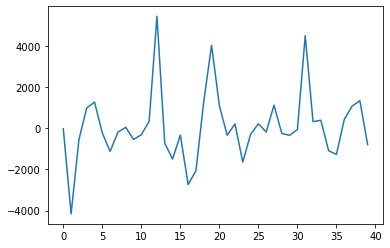

In [13]:
plt.plot(g_loss_history)
plt.show()

In [43]:
for i in range (1000):
    noise = np.random.normal(0, 1, (8, 100))
    sampled_labels = np.asarray(([1,2,3,4,5,6,7,8]))

    fake_images = net_g.predict([noise, sampled_labels])
    fake_images = fake_images*0.5 +0.5
    for j in range(8):
        f_image = PIL.Image.fromarray(np.uint8(fake_images[j,:,:,0]* 255))
        f_image.save('idealized generation 0905/'+str(i*8+j)+'.tif') 

In [44]:
import shutil
shutil.make_archive('idealized generation 0905', 'zip', 'idealized generation 0905')

'/home/jianant/idealized generation 0905.zip'